In [3]:
# Pretrained Network 생성
from tensorflow.python.keras.applications.efficientnet import EfficientNetB0

model_base = EfficientNetB3(weights='imagenet',
                            include_top=False,
                            drop_connect_rate=0.5,
                            input_shape=(224,224,3))

model_base.summary()

Model: "efficientnetb3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, 224, 224, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
normalization_2 (Normalization) (None, 224, 224, 3)  7           rescaling_2[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_2[0][0]            
_____________________________________________________________________________________

In [4]:
### fine tuning

import os
import numpy as np
from tensorflow.python.keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt

base_dir = './data/cat_dog_full'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_datgen = ImageDataGenerator()

validaton_datgen = ImageDataGenerator()

train_generator = train_datgen.flow_from_directory(
    train_dir,
    classes=['cats', 'dogs'], # 명시하지 않으면 순서대로 0부터 매겨짐
    target_size = (224,224),
    batch_size = 100,
    class_mode = 'binary'
)

validation_generator = validaton_datgen.flow_from_directory(
    validation_dir,
    classes=['cats', 'dogs'], # 명시하지 않으면 순서대로 0부터 매겨짐
    target_size = (224,224),
    batch_size = 100,
    class_mode = 'binary'
)

# Pretrained Newtwork
model_base = EfficientNetB3(weights='imagenet',
                            include_top=False,
                            drop_connect_rate=0.5,
                            input_shape=(224,224,3))

model_base.trainable=False # pretrained network의 param을 학습시키지 않고 동결시키기 위한 코드

model = Sequential()

model.add(model_base)

model.add(Flatten(input_shape=(7*7*1536,))) 

model.add(Dense(units=512,
                activation='relu',))
model.add(Dropout(0.5))
model.add(Dense(units=1,
                activation='sigmoid'))

model.summary()

model.compile(optimizer=RMSprop(learning_rate=2e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_generator,
                    steps_per_epoch=140,
                    epochs=30,
                    validation_data = validation_generator,
                    validation_steps=60)



Found 14000 images belonging to 2 classes.
Found 6000 images belonging to 2 classes.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 7, 7, 1536)        10783535  
_________________________________________________________________
flatten_1 (Flatten)          (None, 75264)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               38535680  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 49,319,728
Trainable params: 38,536,193
Non-trainable params: 10,783,535
_________________________________________________________________
Epoch 1/30
140

In [7]:
# 동결 해제
model_base.trainable  = True

for layer in model_base.layers:
    if layer.name in ['block7a_project_conv', 'block7a_se_expand', 
                      'block7a_se_reduce', 'block7a_dwconv']:
        layer.trainable = True
    else:
        layer.trainable = False

# 일반적으로 learning_rate를 더 작게 설정
model.compile(optimizer=RMSprop(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_generator,
                    steps_per_epoch=140,
                    epochs=3,
                    validation_data = validation_generator,
                    validation_steps=60)

Epoch 1/3
140/140 [==============================] - 144s 965ms/step - loss: 0.0254 - accuracy: 0.9949 - val_loss: 0.0727 - val_accuracy: 0.9895
Epoch 2/3
140/140 [==============================] - 133s 946ms/step - loss: 0.0214 - accuracy: 0.9953 - val_loss: 0.0486 - val_accuracy: 0.9912
Epoch 3/3
140/140 [==============================] - 133s 946ms/step - loss: 0.0266 - accuracy: 0.9949 - val_loss: 0.0528 - val_accuracy: 0.9912


{'loss': [0.020913153886795044, 0.030264709144830704, 0.028224872425198555], 'accuracy': [0.9955000281333923, 0.9940714240074158, 0.9949285984039307], 'val_loss': [0.07266318798065186, 0.048570308834314346, 0.0528017058968544], 'val_accuracy': [0.9894999861717224, 0.9911666512489319, 0.9911666512489319]}
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


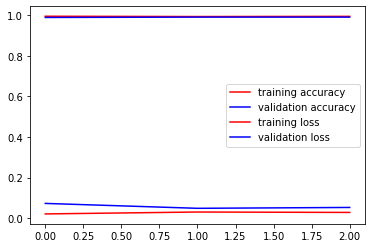

In [8]:
# history 객체를 조사하면 과대적합이 발생했는지 등을 알 수 있음.
print(history.history)
print(history.history.keys())

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_acc, color='r', label='training accuracy') # label은 범례
plt.plot(val_acc, color='b', label='validation accuracy')
plt.legend()  #  범례 표시
# plt.show() # 15 epochs부터는 validation data가 acc이 증가하지 않음.

plt.plot(train_loss, color='r', label='training loss') # label은 범례
plt.plot(val_loss, color='b', label='validation loss')
plt.legend()  #  범례 표시
plt.show() # 15 epochs부터는 validation loss가 줄지 않고 늘어남 (학습의 의미가 없음.)
# 그래프를 보니 과대적합이 발생하는 것을 알 수 있음!
# 데이터가 적기 때문에 overfitting이 발생할 수 밖에 없는 환경임.
